In [1]:
import gym
import random
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython.display import clear_output
import time
import warnings
warnings.filterwarnings('ignore')
import GPy
import GPyOpt
import numpy as np
import pandas as pd

In [3]:
# Environment Settings
env = gym.make('Taxi-v3')
action_size = env.action_space.n 
state_size = env.observation_space.n 

# Init QTable
q_table = np.zeros((state_size, action_size))

In [4]:
'''
    Learn Q-Policy
    Naive
'''
def agentTrainer(q_table, episodes, max_steps, gamma, lr, decay_rate):
    print('Agent Training on Params : lr:{} Gamma:{}'.format(lr, gamma))
    for episode in range(episodes):
        state = env.reset()
        done = False
        step = 0
        if lr <= 0:
            break
        
        for step in range(max_steps):
            # Randomly Choose an Action
            action = env.action_space.sample()
            # Take the action -> observe new state and reward
            new_state, reward, done, info = env.step(action)
            # Update QTable
            q_table[state, action] = q_table[state,action]+lr*(reward+gamma*np.max(q_table[new_state,:])-q_table[state,action])
    
            if done == True:
                #q_table[state, action] = q_table[state, action]+lr*(reward+gamma*0-q_table[state,action])
                break
            state = new_state
        
        episode += 1
        lr -= decay_rate
    
        if (episode % 1000 == 0):
            print('Episode : {} , lr : {}'.format(episode, lr))
            print('-----------')
    return q_table

#q_table = agentTrainer(q_table, 1000, max_steps, gamma, lr, decay_rate)

In [5]:
# Test Q Policy
# http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output
def testPolicy(q_table, max_steps, live=False):
    steps = 0
    penal = 0
    restarts = 0
    
    state = env.reset()
    next_state = env.reset()
    done = False
    total_reward = 0
    while(done == False and steps <= max_steps):
        np.random.seed()
        #env.seed()
        #np.random.RandomState()
        if(next_state == state):
            restarts += 1
            action = np.random.choice(action_size)
            #action = env.action_space.sample() 
            #state = env.reset()
        else:
            state = next_state
            action = np.argmax(q_table[state,:])
        next_state, reward, done, info = env.step(action)

        steps += 1
        if(reward <= -10):
            penal += 1
        total_reward += reward  # Summing rewards
        
        if(steps <= max_steps and live==True):
            env.render()
            print('Episode Reward = {}\nSteps = {}\nPenalities = {}\nRestarts = {}'.\
                format(total_reward, steps, penal, restarts))
            clear_output(wait=True)
            time.sleep(0.10)
            
    return total_reward, steps, penal, restarts

'''q_test_rewards, q_test_steps, q_test_penal, restarts = testPolicy(q_table, 200, True)
print('Episode Reward = {}\nSteps = {}\nPenalities = {}\nRestarts = {}'.\
        format(q_test_rewards, q_test_steps, q_test_penal, restarts))'''

"q_test_rewards, q_test_steps, q_test_penal, restarts = testPolicy(q_table, 200, True)\nprint('Episode Reward = {}\nSteps = {}\nPenalities = {}\nRestarts = {}'.        format(q_test_rewards, q_test_steps, q_test_penal, restarts))"

In [7]:
def f(lr=None, gamma=None, live=False, best_samples=[], opt='BOQTable'):
    '''Static Params'''
    action_size = env.action_space.n 
    state_size = env.observation_space.n 
    max_steps = 1000
    decay_rate = 0.0001
    episodes = 6000
    
    # Initialize Q Table
    q_table = np.zeros((state_size, action_size))
    # Train Agent Q - Params {episodes, max_steps per episode, gamma, learning_rate, decay}
    q_table = agentTrainer(q_table, episodes, max_steps, gamma, lr, decay_rate)
    max_steps = 200
    q_test_rewards, q_test_steps, q_test_penal, restarts = testPolicy(q_table, max_steps, live)
    print('Agent tested for gamma: {} lr: {} => Reward: {}'.format(gamma, lr, q_test_rewards))
    if(best_samples!=[]):
        if(max(best_samples) > q_test_rewards):
            print(q_test_rewards)
            pd.to_pickle(q_table, opt)
    return np.array([q_test_rewards]).reshape(-1,1)

In [8]:
'''
    Parameter Settings for BayOpt
'''
episodes = 4000
lr = 0.3
decay_rate = 0.0001

gamma_params = np.linspace(0.1,1, 20).reshape(-1, 1)
lr_params = np.linspace(0.3,0.6, 20).reshape(-1, 1)
# LR Init & 1Dimensional
'''
X = lr_params
X_i = = np.random.choice(lr_params.flatten())
X_g = np.random.choice(gamma_params.flatten())
X_p = np.array([X_i]).reshape(-1,1)
Y_p = f(lr=X_p[0][0], gamma=0.8)
'''
# Gamma Init
X = gamma_params
X_i = np.random.choice(gamma_params.flatten())
X_predict_sample = np.array([np.random.choice(gamma_params.flatten())]).reshape(-1,1)
X_p = np.array([X_i]).reshape(-1,1)
Y_p = f(lr=lr, gamma=X_p[0][0])

# 2D Hyperparameter Optimization
'''X = np.hstack((gamma_params, lr_params))
X_p = np.vstack((np.random.choice(gamma_params.flatten()), np.random.choice(lr_params.flatten()))).T
Y_p = f(gamma=X[0,0], lr=X[0,1], )'''

Agent Training on Params : lr:0.3 Gamma:0.43157894736842106
Episode : 1000 , lr : 0.200000000000011
-----------
Episode : 2000 , lr : 0.10000000000001855
-----------
Episode : 3000 , lr : 1.671256991304937e-14
-----------
Agent tested for gamma: 0.43157894736842106 lr: 0.3 => Reward: 9


'X = np.hstack((gamma_params, lr_params))\nX_p = np.vstack((np.random.choice(gamma_params.flatten()), np.random.choice(lr_params.flatten()))).T\nY_p = f(gamma=X[0,0], lr=X[0,1], )'

In [9]:
'''
    Kernel & Mean Settings for BayOpt
'''
dims = X.shape[1]
mean_function_k = GPy.mappings.Constant(dims, 1, value=-600)
#mean_function_k = GPy.mappings.Constant(dims, 1, value=0)
mean_function_y = GPy.mappings.Linear(dims,1)
mean_function_y.A = 1000
mf_additive = GPy.mappings.Additive(mean_function_y, mean_function_k)

kernel = GPy.kern.RBF(dims,variance=400,lengthscale=0.1)

'''k1 = GPy.kern.RBF(input_dim=dims,variance=600, lengthscale=0.1)
k2 = GPy.kern.Matern32(input_dim=1,variance=200, lengthscale=0.1)
k3 = GPy.kern.Matern52(input_dim=1,variance=-600, lengthscale=0.1)
kernel =  GPy.kern.Add([k1.copy(),k2.copy(),k3.copy()])'''

#kernel = GPy.kern.RBF(1,variance=600,lengthscale=0.1)

#m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
#gpr = GaussianProcessRegressor(kernel=m52)
#=GPy.mappings.Constant(1, 1, value=0)
#gpr = GPy.models.GPRegression(X_p,Y_p,kernel=kernel)#,mean_function=mean_function_k)

'k1 = GPy.kern.RBF(input_dim=dims,variance=600, lengthscale=0.1)\nk2 = GPy.kern.Matern32(input_dim=1,variance=200, lengthscale=0.1)\nk3 = GPy.kern.Matern52(input_dim=1,variance=-600, lengthscale=0.1)\nkernel =  GPy.kern.Add([k1.copy(),k2.copy(),k3.copy()])'

In [10]:
'''
    * EI, Thompson Sampling, PI
    * Plots - 1D & 2D
'''
%run UtilOpt.ipynb

Agent Training on Params : lr:0.3 Gamma:[0.24210526]
Episode : 1000 , lr : 0.200000000000011
-----------
Episode : 2000 , lr : 0.10000000000001855
-----------
Episode : 3000 , lr : 1.671256991304937e-14
-----------
Agent tested for gamma: [0.24210526] lr: 0.3 => Reward: 3
Agent Training on Params : lr:0.3 Gamma:[0.90526316]
Episode : 1000 , lr : 0.200000000000011
-----------
Episode : 2000 , lr : 0.10000000000001855
-----------
Episode : 3000 , lr : 1.671256991304937e-14
-----------
Agent tested for gamma: [0.90526316] lr: 0.3 => Reward: 6
Agent Training on Params : lr:0.3 Gamma:[0.57368421]
Episode : 1000 , lr : 0.200000000000011
-----------
Episode : 2000 , lr : 0.10000000000001855
-----------
Episode : 3000 , lr : 1.671256991304937e-14
-----------
Agent tested for gamma: [0.57368421] lr: 0.3 => Reward: 10
Agent Training on Params : lr:0.3 Gamma:[0.76315789]
Episode : 1000 , lr : 0.200000000000011
-----------
Episode : 2000 , lr : 0.10000000000001855
-----------
Episode : 3000 , lr :

'plt.figure(figsize=(12,n_iter*3))\nx_opt, f_opt = bayOptEI_2d(n_iter=n_iter, kernel=kernel, X= X, mf=mean_function_k,                        bounds = np.array([[0.1, 1], [0.3, 0.6]]),                        X_init=X_p, Y_init=Y_p, f=f, lr=lr , plotPlots=True)'

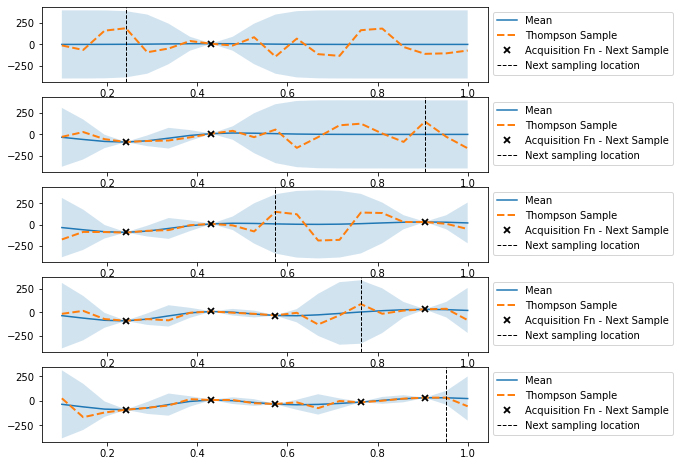

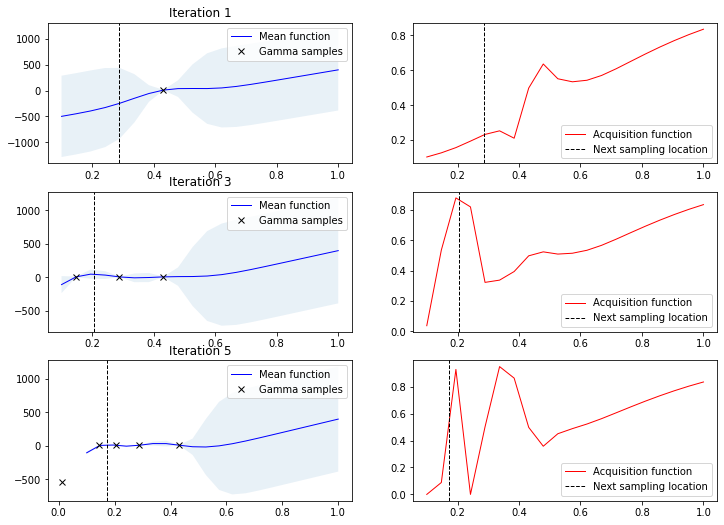

In [11]:
'''
    Methods to call our Acquisition Functions
    1) Thompson Sampling
    2) EI 1D
    3) EI 2D
    3) MPI 1D #set mpi parameter to True
    4) MPI 2D
'''
n_iter = 5
# Thompson Sampling
plt.figure(figsize=(8,8))
x_opt, f_opt = thompson_sampling(n_iter=n_iter, kernel=kernel, X=gamma_params, \
                                 X_init=X_p, Y_init=Y_p, f=f, lr=0.3 ,mf=None,plotPlots=True)

# EI 1D hyperparameter Optimization over Gamma
plt.figure(figsize=(12,n_iter*3))
x_opt, f_opt = bayOptEI(n_iter=n_iter, opt=False, kernel=kernel, X=gamma_params, bounds=np.array([[0.01,0.3]]), \
                        X_init=X_p, Y_init=Y_p, f=f, lr=0.3 ,mf=mf_additive, mpi=True, plotPlots=True)

# EI 1D hyperparameter Optimization over Gamma & lr
'''plt.figure(figsize=(12,n_iter*3))
x_opt, f_opt = bayOptEI_2d(n_iter=n_iter, kernel=kernel, X= X, mf=mean_function_k,\
                        bounds = np.array([[0.1, 1], [0.3, 0.6]]),\
                        X_init=X_p, Y_init=Y_p, f=f, lr=lr , plotPlots=True)'''

In [ ]:
print('Best Gamma: {} for Reward: {}'.format(x_opt[np.argmax(f_opt)][0], np.max(f_opt)))

In [ ]:
'''
    Random Search - Hyperparameter Optimization
'''

# https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html
#from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import ParameterSampler
import numpy as np
'''
Parameters 
Learning Rate (Gradient Descent) - https://keras.io/api/optimizers/adam/
Gamma - Discount Rate - Tradeoff between short Term & Long Term reward for agent
'''
#param_BO = [{'name': 'gamma', 'type': 'continuous', 'domain': (0.1 , 0.99)}]
#param_RS = {"learning_rate": uniform(0.001, 0.2-0.001), "gamma": uniform(0.5, 0.99-0.5)}
param_RS = {"gamma": uniform(0.1, 1.0-0.1)}

def randomElector(param_RS, iters, lr):
    rand_rewards_ = []
    rand_gammas_ = []
    param_list = list(ParameterSampler(param_RS, n_iter= iters,random_state= np.random.RandomState()))
    for idx, params in enumerate(param_list):
        rand_gammas_.append(params['gamma'])
        rand_rewards_.append(f(lr=lr,gamma=params['gamma'],\
                        live=True, best_samples=rand_rewards_, opt='RSQTable')[0][0])
    return rand_gammas_, rand_rewards_

#rand_gammas_, rand_rewards_ = randomElector(param_RS, iters=5, lr=0.2)

In [ ]:
fig = plt.figure()
plt.plot(np.arange(np.array(rand_rewards_).shape[0]), np.array(rand_rewards_))
ax = fig.add_subplot(111)
plt.title('Random Search - QLearning Params')
plt.xlabel('Iterations')
plt.ylabel('Reward')

for xy in zip(np.arange(np.array(rand_rewards_).shape[0]), np.array(rand_rewards_)): 
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')